<a href="https://colab.research.google.com/github/bibekpaudyal1/underWater_sensor_network_simualtion/blob/main/GAAP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt


Number of sensors: 4, Average GAAP  VoI: 16.499344254036814
Number of sensors: 5, Average GAAP  VoI: 18.441833965158718
Number of sensors: 9, Average GAAP  VoI: 24.31217007808305
Number of sensors: 12, Average GAAP  VoI: 27.767764831959244
Number of sensors: 18, Average GAAP  VoI: 33.20959800209222
Number of sensors: 35, Average GAAP  VoI: 46.145729362617715


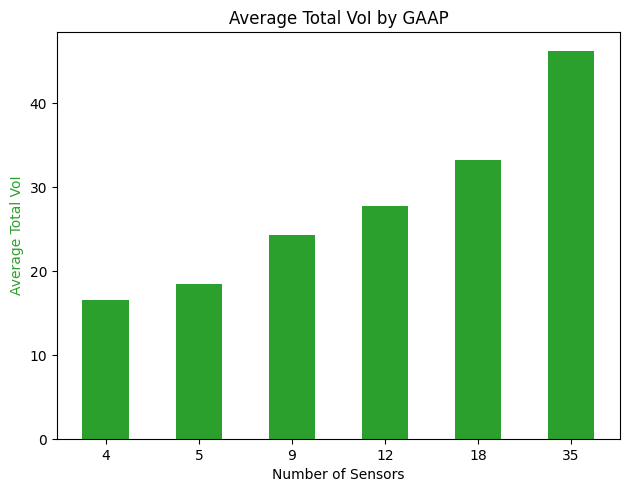

In [ ]:

# Defining variables

areaX = 2000
areaY = 3000
depthMin = 50
depthMax = 100
auvSpeed = 1.8
opticalCommRange = 100
# data in bits
opticalDataRate = 10 * math.pow(10,6)
acousticDataRate = 10 * math.pow(10,3)
videoSizeMB = 9
videoSizeBits = videoSizeMB * 8 * math.pow(10,1)  # in bits
eventRate = 1 / 3600  # Poisson process
simulationTime = 1 * 3600
timeUnit = 300

# Initializing the points for sensors
class UnderwaterSensor:
    def __init__(self, id, x, y, z):
        self.id = id
        self.x = x
        self.y = y
        self.z = z
        self.events = []
        self.dataVolume = 0

    def generateEvent(self, currentTime):
        value = random.uniform(0.4, 20)
        duration = np.random.exponential(3600)  # exponential distribution with mean 1 hour
        self.events.append((currentTime, value, duration))
        self.dataVolume += videoSizeBits

# Initialize sensors
def initializeSensors(numberSensors):
    sensors = []
    for i in range(numberSensors):
        x = random.uniform(0, areaX)
        y = random.uniform(0, areaY)
        z = random.uniform(depthMin, depthMax)
        sensors.append(UnderwaterSensor(i, x, y, z))
    return sensors

# Distance calculation
def calculateDistance(x1, y1, z1, x2, y2, z2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)


#--------------------


def totalDistanceFromAllSensors(sensors):
    totalDistance = 0
    for i in range(len(sensors)):
        for j in range(i+1, len(sensors)):
            totalDistance += calculateDistance(sensors[i].x, sensors[i].y, sensors[i].z, sensors[j].x, sensors[j].y, sensors[j].z)
    return totalDistance


def findWorstStartingPoint(sensors):
    worstStartingPoint = None
    worstDistance = -1

    for sensor in sensors:
        tempSensors = sensors.copy()
        tempSensors.remove(sensor)
        totalDist = totalDistanceFromAllSensors(tempSensors)
        if totalDist > worstDistance:
            worstDistance = totalDist
            worstStartingPoint = (sensor.x, sensor.y, sensor.z)

    return worstStartingPoint

#----------------------

# print(f'There Worst starting point {findWorstStartingPoint}')


# GAAP Algorithm
def gaap(sensors, simulationTime, timeUnit):
    currentTime = 0
    auvPosition = (areaX / 2, areaY / 2, 0) #center

    # auvPosition = (1000,1500,50). # test with specific random point
    # auvPosition = (random.uniform(0, areaX),random.uniform(0,areaY),random.uniform(depthMin,depthMax))
    # auvPosition = findWorstStartingPoint(sensors) #calculating with  worst starting point
    # print(f'The starting point{auvPosition}')

    path = [auvPosition]
    totalVoI = 0

    while currentTime < simulationTime:
        # Generate events
        for sensor in sensors:
            if random.random() < eventRate * timeUnit:
                sensor.generateEvent(currentTime)

        # Determine the next sensor to visit based on VoI
        bestSensor = None
        maxVoI = -1
        for sensor in sensors:
            for event in sensor.events:
                eventTime, value, duration = event
                remainingTime = duration - (currentTime - eventTime)
                if remainingTime > 0:
                    distance = calculateDistance(auvPosition[0], auvPosition[1], auvPosition[2], sensor.x, sensor.y, sensor.z)
                    voi = value * math.exp(-(distance / 1000)) * math.exp(-(currentTime - eventTime) / duration)  # VoI decay over distance and time
                    if voi > maxVoI:
                        maxVoI = voi
                        bestSensor = sensor

        if bestSensor:
            # Move to the best sensor
            distance = calculateDistance(auvPosition[0], auvPosition[1], auvPosition[2], bestSensor.x, bestSensor.y, bestSensor.z)
            travelTime = distance / auvSpeed
            currentTime += travelTime
            if currentTime >= simulationTime:
                break
            auvPosition = (bestSensor.x, bestSensor.y, bestSensor.z)
            path.append(auvPosition)

            # Collect data
            for event in bestSensor.events:
                eventTime, value, duration = event
                remainingTime = duration - (currentTime - eventTime)
                if remainingTime > 0:
                    voi = value * math.exp(-(currentTime - eventTime) / duration)
                    totalVoI += voi
            bestSensor.events = []

            # Surface and transmit data
            surfaceTime = auvPosition[2] / auvSpeed
            currentTime += surfaceTime
            if currentTime >= simulationTime:
                break
            auvPosition = (auvPosition[0], auvPosition[1], 0)
            path.append(auvPosition)

            transmissionTime = videoSizeBits / opticalDataRate
            currentTime += transmissionTime
            if currentTime >= simulationTime:
                break

        # Ensure time advances if no events are processed
        currentTime += timeUnit

    return path, totalVoI

# Simulation function to run multiple times and compare
def runSimulation(num=200):
    numSensorsList = [4, 5, 9, 12, 18, 35]
    avgResultsGAAP = {numSensors: 0 for numSensors in numSensorsList}

    for _ in range(num):
        for numSensors in numSensorsList:
            sensors = initializeSensors(numSensors)
            _, totalVoIGAAP = gaap(sensors, simulationTime, timeUnit)
            avgResultsGAAP[numSensors] += totalVoIGAAP

    # Calculating the average VoI
    for numSensors in numSensorsList:
        avgResultsGAAP[numSensors] /= num

    return avgResultsGAAP

# Run the simulation and get average results
avgResultsGAAP = runSimulation()

# Print average results
for numSensors in avgResultsGAAP.keys():
    print(f"Number of sensors: {numSensors}, Average GAAP  VoI: {avgResultsGAAP[numSensors]}")

# Visualization of average results
def plot(avgResultsGAAP):
    labels = avgResultsGAAP.keys()
    gaapValues = avgResultsGAAP.values()

    x = np.arange(len(labels))
    width = 0.50
    fig, ax = plt.subplots()

    ax.set_xlabel('Number of Sensors')
    ax.set_ylabel('Average Total VoI', color='tab:green')
    rects1 = ax.bar(x, gaapValues, width, label='GAAP', color='tab:green')

    fig.tight_layout()
    plt.title('Average Total VoI by GAAP')
    plt.xticks(x, labels)
    plt.show()

plot(avgResultsGAAP)


Number of sensors: 4, Average Tsp VoI: 2.131848745891194
Number of sensors: 5, Average Tsp VoI: 2.050586130851999
Number of sensors: 9, Average Tsp VoI: 2.9653667059350566
Number of sensors: 12, Average Tsp VoI: 2.7964797194328037
Number of sensors: 18, Average Tsp VoI: 2.440258655045498
Number of sensors: 35, Average Tsp VoI: 3.6142395812423094


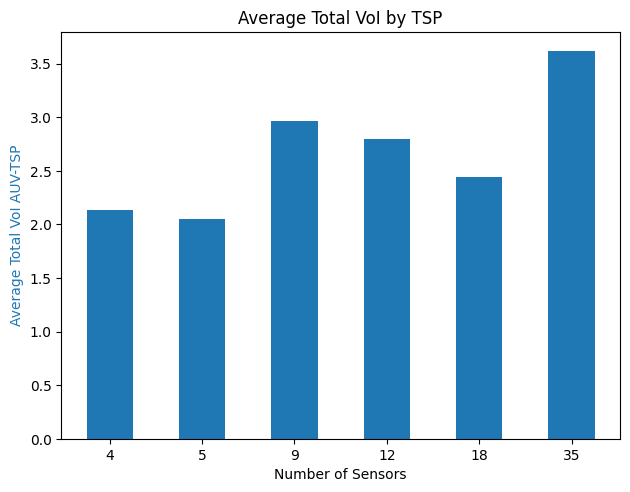

In [ ]:
# Heuristic for TSP
def nearestNeighborTsp(sensors):
    unvisited = sensors.copy()
    currentNode = unvisited.pop(0)
    path = [currentNode]
    while unvisited:
        nearestNode = min(unvisited, key=lambda node: calculateDistance(currentNode.x, currentNode.y, currentNode.z, node.x, node.y, node.z))
        path.append(nearestNode)
        unvisited.remove(nearestNode)
        currentNode = nearestNode
    return path

# AUV-TSP Algorithm
def auvTsp(underwaterSensors, simulationTime, timeUnit):
    currentTime = 0
    auvPosition = (areaX / 2, areaY / 2, 0) # central location
    totalVoI = 0
    path = [auvPosition]  # to store the path

    # Generate initial events
    for sensor in underwaterSensors:
        if random.random() < eventRate * timeUnit:
            sensor.generateEvent(currentTime)

    tspPath = nearestNeighborTsp(underwaterSensors)

    for sensor in tspPath:
        distance = calculateDistance(auvPosition[0], auvPosition[1], auvPosition[2], sensor.x, sensor.y, sensor.z)
        travelTime = distance / auvSpeed
        currentTime += travelTime
        auvPosition = (sensor.x, sensor.y, sensor.z)
        path.append(auvPosition)

        # Collect data
        for event in sensor.events:
            eventTime, value, duration = event
            if currentTime - eventTime < duration:
                voi = value * math.exp(-(currentTime - eventTime) / duration)
                totalVoI += voi

        # Surface and transmit data
        surfaceTime = auvPosition[2] / auvSpeed
        currentTime += surfaceTime
        auvPosition = (auvPosition[0], auvPosition[1], 0)  # surface position
        path.append(auvPosition)

        transmissionTime = videoSizeBits / opticalDataRate
        currentTime += transmissionTime

        currentTime += timeUnit

    return path, totalVoI


def runSimulationTsp(num=200):
    numSensorsList = [4, 5, 9, 12, 18, 35]
    avgResultsTsp = {numSensors: 0 for numSensors in numSensorsList}

    for _ in range(num):
        for numSensors in numSensorsList:
            sensors = initializeSensors(numSensors)
            tspPath, totalVoITsp = auvTsp(sensors, simulationTime, timeUnit)
            avgResultsTsp[numSensors] += totalVoITsp

    # Calculating the average VoI
    for numSensors in numSensorsList:
        avgResultsTsp[numSensors] /= num

    return avgResultsTsp

# Run the simulation and get average results
avgResultsTsp = runSimulationTsp()

# Print average results
for numSensors in avgResultsTsp.keys():
    print(f"Number of sensors: {numSensors}, Average Tsp VoI: {avgResultsTsp[numSensors]}")

# Plotting function
def plot(avgResultsTsp):
    labels = avgResultsTsp.keys()
    tspValues = avgResultsTsp.values()

    x = np.arange(len(labels))
    width = 0.50
    fig, ax = plt.subplots()

    ax.set_xlabel('Number of Sensors')
    ax.set_ylabel('Average Total VoI AUV-TSP', color='tab:blue')
    rects1 = ax.bar(x,tspValues, width, label='AUV-TSP', color='tab:blue')

    fig.tight_layout()
    plt.title('Average Total VoI by TSP')
    plt.xticks(x, labels)
    plt.show()

plot(avgResultsTsp)
